In [4]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Model

In [295]:
class custom_model:

    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(1,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l4=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l5=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l6=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l7=tf.keras.layers.Dense(10,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Running the model

    def run(self, X):
        #with tf.device('/cpu:0'):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.l4(boom2)
        boom4 = self.l5(boom3)
        boom5 = self.l6(boom4)
        boom6 = self.l7(boom5)
        boom7 = self.out(boom6)
        return boom7

    def get_loss(self, Xf):
    
        with tf.GradientTape() as tape:
            tape.watch(Xf)
            
            with tf.GradientTape() as tape1:
                tape1.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.l4(boom2)
                boom4 = self.l5(boom3)
                boom5 = self.l6(boom4)
                boom6 = self.l7(boom5)
                boom7 = self.out(boom6)
                g = tape1.gradient(boom7, Xf)
            gg = tape.gradient(g, Xf)
        
        l = 1.5
        
        #y_l = g[:, 0]
        y_x = g[:, 0]
        #y_xx = gg[:, 1]
        y = boom7[:, 0]
        
        #print('u_t: ', u_t)
        #print('u_x: ', u_x)
        #print('u_xx: ', u_xx)
        #print('u: ', u)
        
        L = y*tf.math.sqrt(1 + y_x*y_x)
        #print('L', L)
        MSEf = self.SC_int(0, 1, len(Xf)-1, L)
        
        ######### boundary conditions #########
        YB = 1.
        Y_B_predict = self.run(tf.constant([[0.], [1.]]))
        MSEb = tf.reduce_mean((Y_B_predict - YB)**2)
        
        
        ######### length condition #########
        length_integrand = tf.math.sqrt(1 + y_x*y_x)
        MSEl = (self.SC_int(0, 1, len(Xf)-1, length_integrand) - l)**2
        
        
        return MSEb + MSEf + 2*MSEl

    def get_grad(self, Xf):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.l4.variables)
            tape.watch(self.l5.variables)
            tape.watch(self.l6.variables)
            tape.watch(self.l7.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Xf)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.l6.variables[0],self.l6.variables[1],self.l7.variables[0],self.l7.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent

    def network_learn(self, Xf):
        g = self.get_grad(Xf)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.l4.variables[0],self.l4.variables[1],self.l5.variables[0],self.l5.variables[1],self.l6.variables[0],self.l6.variables[1],self.l7.variables[0],self.l7.variables[1],self.out.variables[0],self.out.variables[1]]))

    def SC_int(self, x0, x1, n, L):
        
        h = (x1-x0)/n
        S = L[0] + L[n]
        
        for i in range(1,n):
            if i%2==0:
                S = S + 2*L[i]
            else:
                S = S + 4*L[i]
        
        return (h/3)*S
    
    
    def get_length(self, Xf):
        
        with tf.GradientTape() as tape:
                tape.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.l4(boom2)
                boom4 = self.l5(boom3)
                boom5 = self.l6(boom4)
                boom6 = self.l7(boom5)
                boom7 = self.out(boom6)
                g = tape.gradient(boom7, Xf)
        
        y_x = g[:, 0]
        length_integrand = tf.math.sqrt(1 + y_x*y_x)
        return self.SC_int(0, 1, len(Xf)-1, length_integrand)

### Model

In [296]:
Model = custom_model()

### Training Set

In [297]:
X_points = tf.constant([[i*0.01] for i in range(101)])

### Training

In [310]:
start = timeit.default_timer()
epochs = 100
Loss = []
for i in range(epochs):
    if i % 1 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss(X_points).numpy()
        Loss.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
    if i%(epochs/5)==0:
        #print((i/epochs)*100, '%')
        print((i/epochs)*100, '%', end='\r')
    print
    
    Model.network_learn(X_points)


stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  9.813526199999615


### Plot The Loss

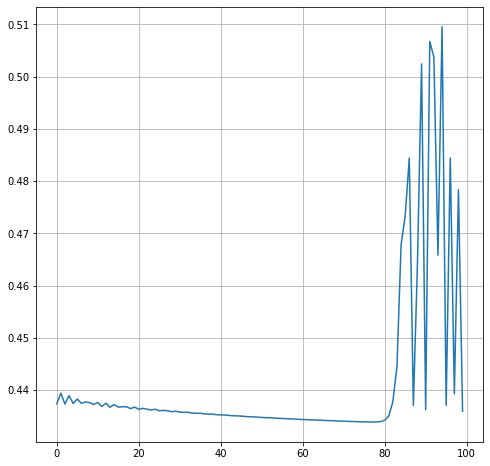

In [311]:
plt.figure(figsize=(8, 8))
plt.plot(Loss[0:100])
plt.grid()
plt.show()

### Plot

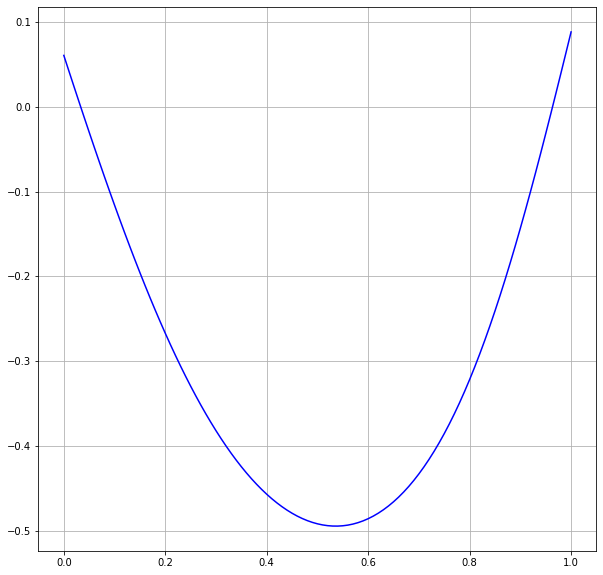

In [312]:

fig = plt.figure(figsize=(10, 10))
x = [i*0.01 for i in range(0,101)]
u = []
for i in x:
    u.append(Model.run(tf.constant([[i]]))[:, 0].numpy())
    
#plt.ylim(-1, 0)
#plt.xlim(0,1)
#plt.plot(x, u)
plt.plot(x, u, color='b')
plt.grid()
plt.show()

In [313]:
tf.reduce_mean((Model.run(tf.constant([[0.], [1.]])) )**2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.005715603>

In [314]:
Model.get_length(X_points)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5899738>

In [309]:
Model.get_loss(X_points)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4374022>